In [ ]:
!python --version

Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I. Preprocessing data

In [ ]:
import pandas as pd

train_file = pd.read_csv('/content/coffee.csv', encoding='utf-8')

In [ ]:
train_file

,Question,infomation,productTopSell,recommendedProduct,ingredient,quality,greeting
0,cho tớ hỏi quán đang bán chạy sản phẩm nào,0,1,0,0,0,0
1,bạn có thể cho tớ thông tin về những sản phẩm ...,0,1,0,0,0,0
2,bạn cho mình xin thông tin về sản phẩm nào đượ...,0,0,0,1,0,0
3,mình cần bạn giải đáp sản phẩm espresso có đán...,0,0,0,0,1,0
4,cậu giúp mình với có cà phê nào mà em không nê...,0,0,1,0,0,0
...,...,...,...,...,...,...,...
18702,mình có một câu hỏi mô tả chi tiết về espresso...,1,0,0,0,0,0
18703,bạn có thể cho tớ thông tin về có nên tin tưởn...,0,0,0,0,1,0
18704,bạn có thể cung cấp thông tin về có cà phê nào...,0,0,1,0,0,0
18705,có thể giúp mình giải đáp giá bán của espresso...,1,0,0,0,0,0


In [ ]:
train_contexts = train_file['Question'].tolist()

In [ ]:
train_contexts

['cho tớ hỏi quán đang bán chạy sản phẩm nào',
 'bạn có thể cho tớ thông tin về những sản phẩm nào đang bán chạy nhất trong hệ thống của Quán',
 'bạn cho mình xin thông tin về sản phẩm nào được chế biến bởi phô mai',
 'mình cần bạn giải đáp sản phẩm espresso có đáng mua không',
 'cậu giúp mình với có cà phê nào mà em không nên bỏ lỡ không',
 'có thể cho mình biết thành phần của americano không',
 'bạn có thể cho tớ thông tin về sản phẩm nào được chế biến bởi bơ',
 'bạn giúp mình chút được không có nên tin tưởng vào chất lượng của americano không',
 'có thể cho mình biết nhiều người đánh giá espresso cao không',
 'bạn có thể cho tớ thông tin về cà phê nào anh nên thử',
 'mình cần chút thông tin về anh có thể thử cà phê nào',
 'mình có một câu hỏi mình có thể tham khảo cà phê nào',
 'cho mình hỏi sản phẩm nào có bột mì',
 'bạn cho mình hỏi americano giá bao nhiêu',
 'mình có điều muốn hỏi thành phần của americano không',
 'mình muốn hỏi gợi ý cho bạn cà phê tương tự với',
 'mình thắc mắc

In [ ]:
train_labels = train_file.drop(columns=['Question'])

In [ ]:
train_labels

,infomation,productTopSell,recommendedProduct,ingredient,quality,greeting
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,0,1,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
18702,1,0,0,0,0,0
18703,0,0,0,0,1,0
18704,0,0,1,0,0,0
18705,1,0,0,0,0,0


In [ ]:
train_labels = train_labels.to_numpy()

In [ ]:
print(train_labels.shape)

(18707, 6)


# II. Model

In [2]:
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Lambda, Dense, Concatenate, Conv1D, GlobalAveragePooling1D, Dropout, BatchNormalization, Bidirectional, LSTM, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

## Input model

<Axes: >

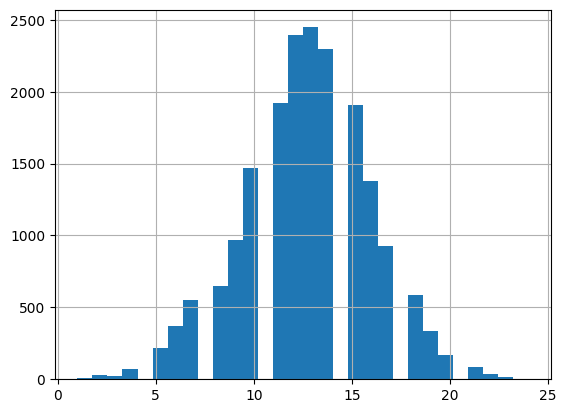

In [ ]:
seq_len = [len(i.split()) for i in train_contexts]
pd.Series(seq_len).hist(bins = 30)

In [5]:
# Configuration and Model Parameters
MAX_LEN_CONTEXT = 25
bert_name = "vinai/phobert-base"
LEARNING_RATE = 1e-5
BATCH_SIZE = 64
EPOCHS = 20

In [6]:
# Load pre-trained BERT model and tokenizer
bert = TFAutoModel.from_pretrained(bert_name)
tokenizer = AutoTokenizer.from_pretrained(bert_name)

class BERTEmbeddingLayer(Layer):
    def __init__(self, bert_model_name, max_length, **kwargs):
        super(BERTEmbeddingLayer, self).__init__(**kwargs)
        self.bert_model_name = bert_model_name
        self.max_length = max_length
        # Load the BERT model inside the layer
        self.bert = TFAutoModel.from_pretrained(bert_model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Obtain BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # Equivalent to outputs[0]

    def get_config(self):
        config = super(BERTEmbeddingLayer, self).get_config()
        config.update({
            'bert_model_name': self.bert_model_name,
            'max_length': self.max_length,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Define input layers
attention_mask_context = Input(shape=(MAX_LEN_CONTEXT,), dtype=tf.int32, name='attention_mask_context')
input_ids_context = Input(shape=(MAX_LEN_CONTEXT,), dtype=tf.int32, name='input_ids_context')

# Use the custom BERT embedding layer
embedding_context = BERTEmbeddingLayer(bert_model_name=bert_name, max_length=MAX_LEN_CONTEXT)(
    [input_ids_context, attention_mask_context]
)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
# CNN Branch
cnn_branch = Conv1D(256, kernel_size=3, padding='same', activation='relu')(embedding_context)
cnn_branch = BatchNormalization()(cnn_branch)
cnn_branch = Conv1D(128, kernel_size=3, activation='relu')(cnn_branch)
cnn_branch = GlobalAveragePooling1D()(cnn_branch)
cnn_branch = Dense(64, activation='relu')(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)

In [ ]:
# LSTM Branch
lstm_branch = Bidirectional(LSTM(64, return_sequences=False))(embedding_context)
lstm_branch = BatchNormalization()(lstm_branch)
lstm_branch = Dense(64, activation='relu')(lstm_branch)
lstm_branch = Dropout(0.3)(lstm_branch)

In [ ]:
# Combine branches
combined = Concatenate()([cnn_branch, lstm_branch])
combined = Dense(64, activation='relu')(combined)  # Additional Dense layer

# Output layer
output = Dense(train_labels.shape[1], activation='softmax')(combined)

# Define the full model
model = Model(inputs=[input_ids_context, attention_mask_context], outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids_context         │ (None, 25)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask_context    │ (None, 25)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_embedding_layer      │ (None, 25, 768)        │              0 │ input_ids_context[0][… │
│ (BERTEmbeddingLayer)      │                        │                │ attention_mask_contex… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 25, 256)        │        590,080 │ bert_embedding_layer[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 25, 256)        │          1,024 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 23, 128)        │         98,432 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │        426,496 │ bert_embedding_layer[… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ conv1d_1[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ bidirectional[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 1,141,702 (4.36 MB)

 Trainable params: 1,140,934 (4.35 MB)

 Non-trainable params: 768 (3.00 KB)

## Train

In [ ]:
# Tokenize training data
train_context_encodings = tokenizer(
    train_contexts, truncation=True, padding='max_length',
    max_length=MAX_LEN_CONTEXT, add_special_tokens=True
)

train_context_features = {
    key: tf.convert_to_tensor(train_context_encodings[key], dtype=tf.int32)
    for key in tokenizer.model_input_names
}

train_context_input_ids = train_context_features['input_ids']
train_context_attention_mask = train_context_features['attention_mask']

In [ ]:
# Compute class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(np.argmax(train_labels, axis=1)), y=np.argmax(train_labels, axis=1)
)
class_weights = dict(enumerate(class_weights))

# Set up early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [ ]:
# Fit the model
history = model.fit(
    [train_context_input_ids, train_context_attention_mask],
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 55s 151ms/step - categorical_accuracy: 0.2343 - loss: 1.8272 - val_categorical_accuracy: 0.5898 - val_loss: 1.4357 - learning_rate: 1.0000e-05
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - categorical_accuracy: 0.5515 - loss: 1.1456 - val_categorical_accuracy: 0.8492 - val_loss: 0.8552 - learning_rate: 1.0000e-05
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - categorical_accuracy: 0.7747 - loss: 0.7373 - val_categorical_accuracy: 0.8980 - val_loss: 0.5065 - learning_rate: 1.0000e-05
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - categorical_accuracy: 0.8706 - loss: 0.4699 - val_categorical_accuracy: 0.9261 - val_loss: 0.3259 - learning_rate: 1.0000e-05
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - categorical_accuracy: 0.9045 - loss: 0.3239 - val_categorical_accuracy: 0.9494 - val_loss: 0.2217 - learning_rate: 1.0000e-05
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - categorical_accuracy: 0.9359

In [ ]:
print(history.history.keys())

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


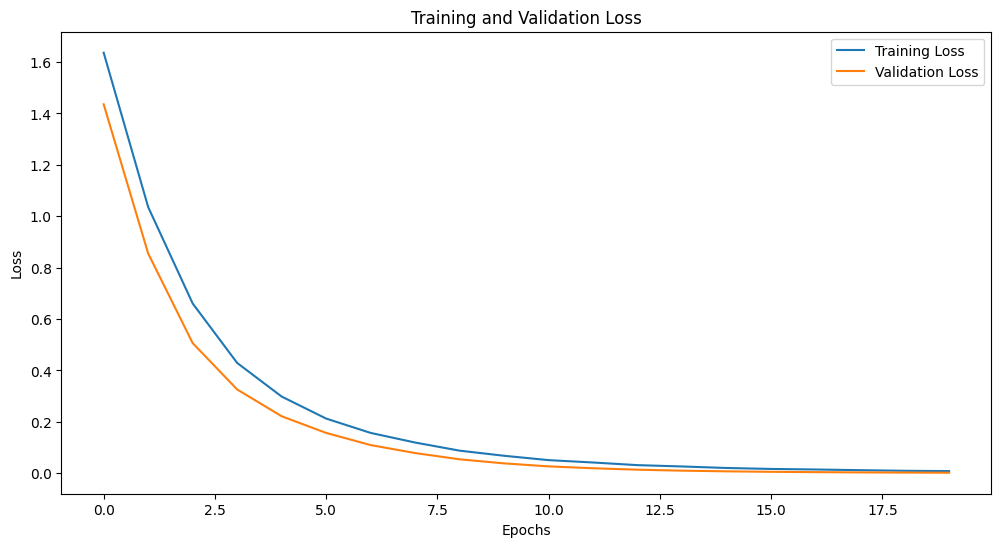

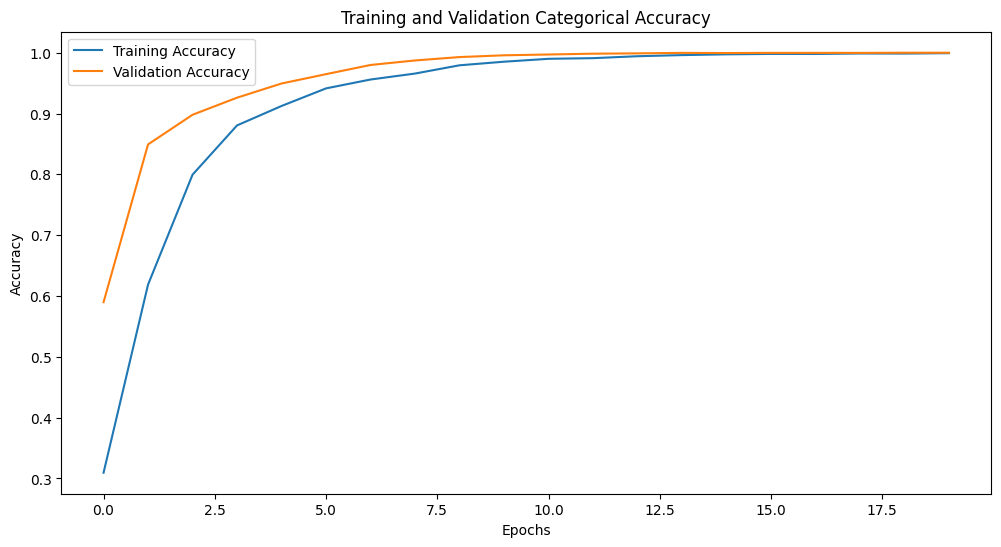

In [ ]:
import matplotlib.pyplot as plt

# Biểu đồ Loss cho Training và Validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Biểu đồ Accuracy cho Training và Validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Test

In [7]:
model = tf.keras.models.load_model('model_coffee_question_classification.keras', custom_objects={'BERTEmbeddingLayer': BERTEmbeddingLayer})

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [8]:
test_contexts = ["cà phê còn hàng không",
                 "gợi ý các cà phê tương tự với",
                 "cửa hàng gợi ý sản phẩm cho tớ được không",
                 "cho tôi các sản phẩm bán chạy nhất",
                 "danh sách sản phẩm bán chạy hàng đầu",
                 "cà phê quán này ngon không",
                 "Espresso với americano cái nào ngon hơn",
                 "cho hỏi thông tin về cà phê Espresso",
                 "cà phê sữa còn bao nhiêu ly",
                 "Espresso giá như nào",
                 "xin chào nhaaaaa",
                 "cà phê nào ngon nhất",
                 "cà phê đá và cà phê sữa nào ngon hơn",
                 "cà phê có ngon không"]

In [9]:
# Tokenize the test contexts
test_encodings = tokenizer(
    test_contexts,
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN_CONTEXT,
    add_special_tokens=True,
    return_tensors='tf'
)

# Prepare input tensors
test_input_ids = test_encodings['input_ids']
test_attention_mask = test_encodings['attention_mask']

# Make predictions using the model
predictions = model.predict([test_input_ids, test_attention_mask], batch_size=32)

# Convert predictions to class labels (e.g., using argmax)
predicted_classes = np.argmax(predictions, axis=1)

# If you have a dictionary mapping from class indices to class labels, apply it
# Example:
label_mapping = {0: 'infomation', 1: 'productTopSell', 2: 'recommendedProduct', 3: 'ingredient', 4: 'quality', 5: 'greeting'}
predicted_labels = [label_mapping.get(pred, 'unknown') for pred in predicted_classes]

# Print the predicted labels
for context, label in zip(test_contexts, predicted_labels):
    print(f"Question: {context} --> Predicted Label: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Question: cà phê còn hàng không --> Predicted Label: infomation
Question: gợi ý các cà phê tương tự với --> Predicted Label: recommendedProduct
Question: cửa hàng gợi ý sản phẩm cho tớ được không --> Predicted Label: recommendedProduct
Question: cho tôi các sản phẩm bán chạy nhất --> Predicted Label: productTopSell
Question: danh sách sản phẩm bán chạy hàng đầu --> Predicted Label: productTopSell
Question: cà phê quán này ngon không --> Predicted Label: quality
Question: Espresso với americano cái nào ngon hơn --> Predicted Label: quality
Question: cho hỏi thông tin về cà phê Espresso --> Predicted Label: infomation
Question: cà phê sữa còn bao nhiêu ly --> Predicted Label: infomation
Question: Espresso giá như nào --> Predicted Label: infomation
Question: xin chào nhaaaaa --> Predicted Label: greeting
Question: cà phê nào ngon nhất --> Predicted Label: recommendedProduct
Question: cà phê đá và cà phê sữa nào ngon hơn --> Predicted Label: quality
Que

In [ ]:
model.save('model_coffee_question_classification.keras')

## Get message